#**Modelos Lineares Generalizados (GLM) em Python**

# Profª Msc. Viviane Costa Silva

Disciplina de Seminários - Universidade Estadual da Paraíba  - UEPB


# **1. Objetivos de aprendizagem**

Ao final da aula, os alunos deverão ser capazes de:


*   Entender a estrutura matemática de um GLM: família, função de ligação e preditor linear.
*   Escolher família e link apropriados para tipos de resposta (binária, contagem, contínua positiva).
*   Ajustar GLMs em Python usando statsmodels e interpretar coeficientes.
*   Diagnosticar problemas de ajuste (overdispersion, resíduos, influência).
*   Ajustar variantes (NegBin, quasi-Poisson, Gamma) quando necessário.



# **2. Prática**

# **Exemplo 1: Regressão Logística (Titanic)**

In [50]:
# ----------------- Exemplo 1: Regressão Logística (Titanic) -----------------
# imports essenciais
import pandas as pd                                   # manipulação de dados
import numpy as np                                    # funções matemáticas
import seaborn as sns                                 # gráficos estatísticos
import matplotlib.pyplot as plt                       # personalização de plots
import statsmodels.api as sm                          # ajuste de modelos GLM
from sklearn.metrics import roc_curve, roc_auc_score  # métricas ROC/AUC

sns.set_theme(style="whitegrid", font_scale=1.15)     # estilo global agradável

In [51]:
# 1) Carregar e limpar dados
df = sns.load_dataset('titanic')                      # carregar dataset do seaborn
print("Dimensão original:", df.shape)                 # ver tamanho inicial
df = df.dropna(subset=['age', 'fare', 'sex', 'survived'])  # remover linhas com NA nas colunas usadas
print("Dimensão após dropna:", df.shape)

Dimensão original: (891, 15)
Dimensão após dropna: (714, 15)


In [52]:
# 2) Feature engineering simples
df['sex_male'] = (df['sex'] == 'male').astype(int)    # transformar 'sex' em variável binária 0/1
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,sex_male
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,1
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,0
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,0
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,0
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q,Third,woman,False,NaN,Queenstown,no,False,0
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True,1
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True,0
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True,1


In [53]:
# 3) Definir matriz de preditores X e vetor resposta y
X = df[['age', 'fare', 'sex_male']]                   # escolher colunas explicativas
X = sm.add_constant(X)                                # adicionar intercept (constante)
y = df['survived']                                    # variável resposta (0/1)


In [54]:
# 4) Ajustar GLM binomial (logit é link padrão)
modelo_logit = sm.GLM(y, X, family=sm.families.Binomial())
res_logit = modelo_logit.fit()                        # estimação por MLE
print(res_logit.summary())                            # sumário completo (coef, std err, z, p>|z|, etc.)


                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      710
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -358.04
Date:                Mon, 10 Nov 2025   Deviance:                       716.07
Time:                        00:42:23   Pearson chi2:                     701.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2939
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9348      0.239      3.910      0.0

In [55]:
# 5) Resultados transformados (odds ratios) e intervalos de confiança
odds_ratios = np.exp(res_logit.params)                # exp(beta) -> odds ratio
conf = res_logit.conf_int()                           # intervalo de confiança dos betas
conf_odds = np.exp(conf)                              # intervalo de confiança em escala de odds
or_table = pd.DataFrame({
    'coef': res_logit.params,
    'OR': odds_ratios,
    'CI_lower': conf_odds[0],
    'CI_upper': conf_odds[1],
    'pvalue': res_logit.pvalues
})
print("\nTabela de Odds Ratios e IC (95%):\n", or_table)


Tabela de Odds Ratios e IC (95%):
               coef        OR  CI_lower  CI_upper        pvalue
const     0.934841  2.546808  1.593943  4.069299  9.236838e-05
age      -0.010570  0.989486  0.976964  1.002169  1.038333e-01
fare      0.012773  1.012855  1.007517  1.018221  2.157090e-06
sex_male -2.347599  0.095598  0.065881  0.138721  4.373466e-35


In [56]:
# 6) Previsões e AUC
probs = res_logit.predict(X)                          # probabilidades preditas
auc = roc_auc_score(y, probs)                         # AUC (0.5~aleatório, 1~perfeito)
print(f"\nAUC: {auc:.3f}")



AUC: 0.825


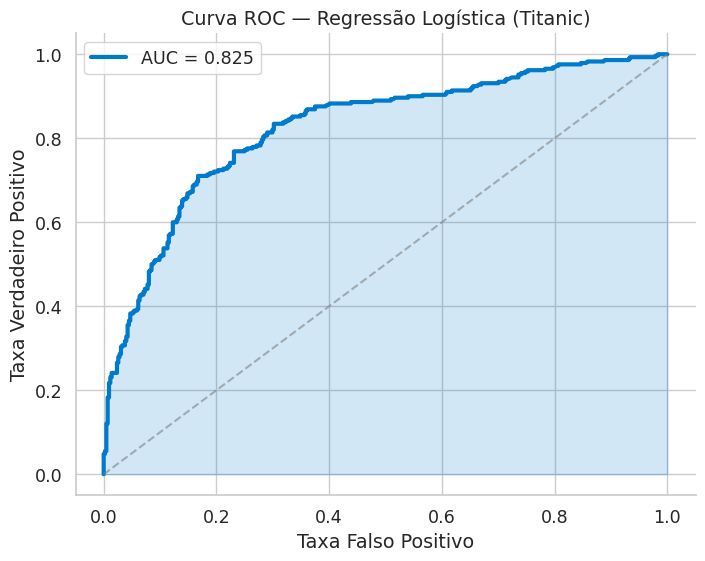

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

In [57]:
# 7) Plots chamativos: curva ROC e probabilidade predita vs idade
fpr, tpr, _ = roc_curve(y, probs)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="#007acc", lw=3, label=f"AUC = {auc:.3f}")
plt.fill_between(fpr, tpr, alpha=0.18, color="#007acc")
plt.plot([0,1], [0,1], '--', color='gray', alpha=0.6)
plt.xlabel("Taxa Falso Positivo")
plt.ylabel("Taxa Verdadeiro Positivo")
plt.title("Curva ROC — Regressão Logística (Titanic)")
plt.legend()
sns.despine()
plt.show()

plt.figure(figsize=(8,6))



# **Exemplo 2 — Regressão de Contagem (Poisson)**

In [58]:
# ----------------- Exemplo 2: Poisson (contagem) -----------------

import pandas as pd                     # Biblioteca para manipulação de dados (DataFrames)
import numpy as np                      # Biblioteca numérica para cálculos e geração de dados
import seaborn as sns                   # Biblioteca para visualizações bonitas e estatísticas
import matplotlib.pyplot as plt         # Biblioteca para personalizar gráficos
import statsmodels.api as sm            # Biblioteca para ajustar modelos estatísticos, incluindo GLM

sns.set_theme(style="whitegrid", font_scale=1.1)  # Define um estilo visual agradável para os gráficos


In [59]:
# 1) SIMULAR DADOS ARTIFICIAIS

np.random.seed(42)                     # Garante reprodutibilidade da simulação (resultados sempre iguais)
n = 200                                # Tamanho da amostra: 200 observações

# Cria DataFrame com duas variáveis explicativas contínuas
df2 = pd.DataFrame({
    'horas_trabalho': np.random.uniform(4, 10, n),   # gera valores entre 4 e 10
    'experiencia': np.random.uniform(1, 10, n)       # gera valores entre 1 e 10
})


In [60]:
# Gera a média (λ) da distribuição Poisson usando o link log: log(λ) = 0.5 + 0.1*horas + 0.05*experiência
lam = np.exp(0.5 + 0.1*df2['horas_trabalho'] + 0.05*df2['experiencia'])

# Gera contagens Poisson reais a partir da média λ
df2['chamadas'] = np.random.poisson(lam=lam)

df2.head()  # Mostra as primeiras linhas


,horas_trabalho,experiencia,chamadas
0,6.247241,6.778285,4
1,9.704286,1.757260,2
2,8.391964,2.454658,6
3,7.591951,9.086988,7
4,4.936112,6.457862,2


In [61]:
# 2) Preparar X (preditores) e y (resposta)

X2 = sm.add_constant(df2[['horas_trabalho', 'experiencia']])  # adiciona o intercepto β₀
y2 = df2['chamadas']                                          # variável resposta


In [62]:
# 3) Ajustar o modelo de regressão Poisson

modelo_pois = sm.GLM(y2, X2, family=sm.families.Poisson())  # família = Poisson (distribuição de contagem)
res_pois = modelo_pois.fit()                                # estima os parâmetros por MLE
print(res_pois.summary())                                   # exibe resumo completo do modelo


                 Generalized Linear Model Regression Results                  
Dep. Variable:               chamadas   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -416.60
Date:                Mon, 10 Nov 2025   Deviance:                       188.77
Time:                        00:42:24   Pearson chi2:                     173.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1381
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6454      0.163      3.

In [63]:
# 4) Transformar os coeficientes para escala interpretável (fatores multiplicativos)
fatores = np.exp(res_pois.params)
print("\nFatores multiplicativos (exp(beta)):\n", fatores)



Fatores multiplicativos (exp(beta)):
 const             1.906756
horas_trabalho    1.102610
experiencia       1.027337
dtype: float64


In [64]:
# 5) Diagnóstico de sobredispersão
deviance = res_pois.deviance
df_resid = res_pois.df_resid
dispersion_ratio = deviance / df_resid

pearson_chi2 = np.sum(res_pois.resid_pearson**2)
pearson_ratio = pearson_chi2 / df_resid

print(f"\nDeviance/DF = {dispersion_ratio:.3f}")
print(f"Pearson Chi2/DF = {pearson_ratio:.3f}")

# Idealmente, Deviance/DF ≈ 1 indica que o modelo Poisson está adequado.
# Se for > 1.5, há sobredispersão → considerar modelo Binomial Negativo (NegBin).



Deviance/DF = 0.958
Pearson Chi2/DF = 0.878


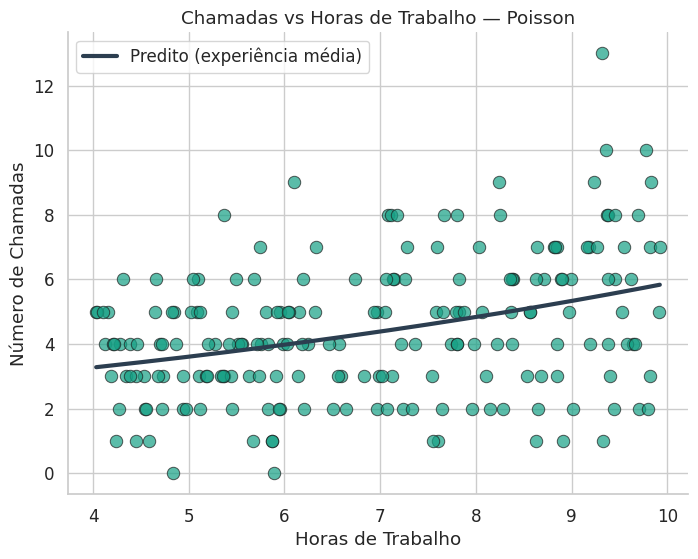

In [65]:
# 6) Visualizar relação entre horas de trabalho e chamadas
df2['pred_media'] = res_pois.predict(X2)  # adiciona predições da média

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='horas_trabalho', y='chamadas', data=df2,
    s=80, color='#16a085', edgecolor='k', alpha=0.7
)
# gera linha de predição mantendo experiência média
x_seq = np.linspace(df2['horas_trabalho'].min(), df2['horas_trabalho'].max(), 200)
# Create a DataFrame with both 'horas_trabalho' and the mean of 'experiencia'
# Ensure the column order and names match X2
pred_df = pd.DataFrame({
    'const': 1, # Add the constant column
    'horas_trabalho': x_seq,
    'experiencia': df2['experiencia'].mean() # Use the mean experience for all predictions
})

pred_line = res_pois.predict(pred_df)

plt.plot(x_seq, pred_line, color='#2c3e50', lw=3, label='Predito (experiência média)')
plt.xlabel("Horas de Trabalho")
plt.ylabel("Número de Chamadas")
plt.title("Chamadas vs Horas de Trabalho — Poisson")
plt.legend()
sns.despine()
plt.show()

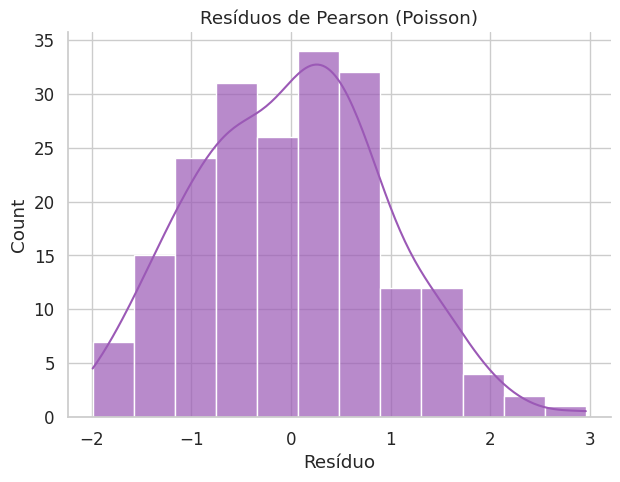

In [66]:
# 7) Histograma dos resíduos de Pearson (para verificar ajuste)
plt.figure(figsize=(7,5))
sns.histplot(res_pois.resid_pearson, kde=True, color='#9b59b6', alpha=0.7)
plt.title("Resíduos de Pearson (Poisson)")
plt.xlabel("Resíduo")
sns.despine()
plt.show()


# **Exemplo 3 — Regressão Gamma (Tempo de Espera)**

Modelar tempo de espera médio em função do número de clientes e funcionários (variável contínua e positiva).

In [67]:
# ----------------- Exemplo 3: Gamma (tempo de espera) -----------------
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

sns.set_theme(style="whitegrid", font_scale=1.1)


In [68]:
# 1) Simular dados positivos
np.random.seed(123)
n = 200

# Cria variáveis explicativas
df3 = pd.DataFrame({
    'clientes': np.random.randint(10, 50, n),     # número de clientes atendidos
    'funcionarios': np.random.randint(1, 6, n)    # número de funcionários
})


In [69]:
# Define o parâmetro "scale" para gerar tempos médios de espera
scale = (df3['clientes'] / df3['funcionarios']) / 20.0

# Gera tempos positivos com distribuição Gamma
df3['tempo_espera'] = np.random.gamma(shape=2.0, scale=scale)
df3.head()


,clientes,funcionarios,tempo_espera
0,12,4,0.048234
1,38,2,0.375043
2,44,3,4.544658
3,48,5,0.533397
4,27,2,0.170024


In [70]:
# 2) Definir X e y
X3 = sm.add_constant(df3[['clientes', 'funcionarios']])  # inclui intercepto
y3 = df3['tempo_espera']


In [71]:
# 3) Ajustar GLM com família Gamma e link log
modelo_gamma = sm.GLM(
    y3, X3,
    family=sm.families.Gamma(link=sm.families.links.log())
)
res_gamma = modelo_gamma.fit()
print(res_gamma.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:           tempo_espera   No. Observations:                  200
Model:                            GLM   Df Residuals:                      197
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                         0.47026
Method:                          IRLS   Log-Likelihood:                -203.20
Date:                Mon, 10 Nov 2025   Deviance:                       110.34
Time:                        00:42:24   Pearson chi2:                     92.6
No. Iterations:                    14   Pseudo R-squ. (CS):             0.6760
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0281      0.155      0.181   

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [72]:
# 4) Transformar coeficientes para escala interpretável
efeitos = np.exp(res_gamma.params)
print("\nEfeitos multiplicativos exp(beta):\n", efeitos)



Efeitos multiplicativos exp(beta):
 const           1.028507
clientes        1.044323
funcionarios    0.669958
dtype: float64


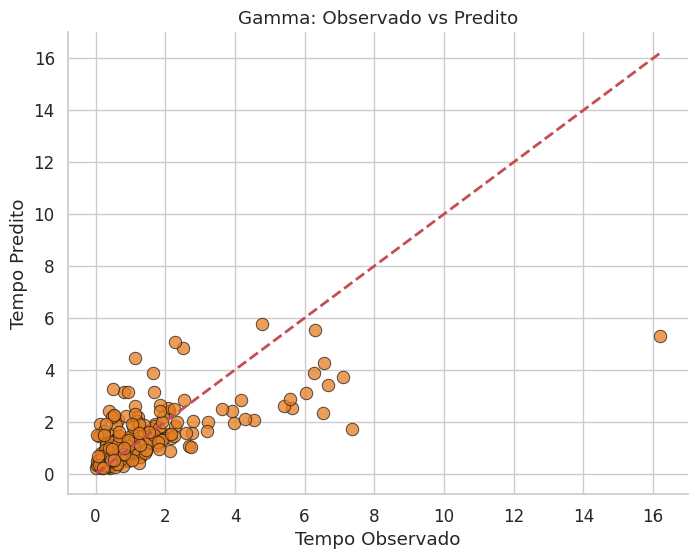

In [73]:
# 5) Predição e gráfico Observado vs Predito
df3['pred'] = res_gamma.predict(X3)
plt.figure(figsize=(8,6))
sns.scatterplot(x=y3, y=df3['pred'], s=80, color='#e67e22', edgecolor='k', alpha=0.75)
plt.plot([y3.min(), y3.max()], [y3.min(), y3.max()], 'r--', lw=2)
plt.xlabel("Tempo Observado")
plt.ylabel("Tempo Predito")
plt.title("Gamma: Observado vs Predito")
sns.despine()
plt.show()


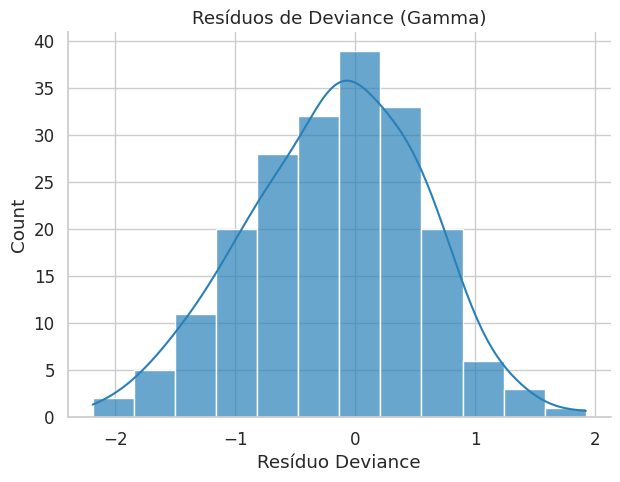

In [74]:
# 6) Histograma dos resíduos de Deviance
plt.figure(figsize=(7,5))
sns.histplot(res_gamma.resid_deviance, kde=True, color='#2980b9', alpha=0.7)
plt.title("Resíduos de Deviance (Gamma)")
plt.xlabel("Resíduo Deviance")
sns.despine()
plt.show()


# **Overdispersion, resíduos e pontos influentes (Cook’s distance)**

In [75]:
# ============================================================
# Diagnóstico de Modelo GLM (Poisson) — Overdispersion e Influência
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


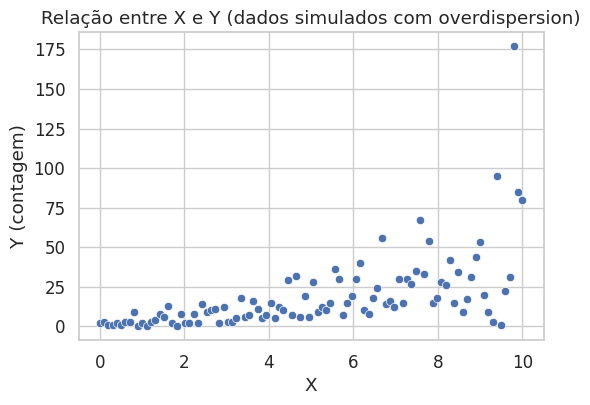

In [76]:

# ------------------------------------------------------------
# 1. Gerar dados simulados com overdispersion
# ------------------------------------------------------------

np.random.seed(42)

# Variável preditora (x) — de 0 a 10
x = np.linspace(0, 10, 100)

# Gerar média (mu) de contagem a partir de uma relação exponencial
mu = np.exp(1 + 0.3 * x)

# Gerar contagens de Y com overdispersion (usando uma distribuição Gamma-Poisson)
# Gamma-Poisson gera uma contagem com variância > média
y = np.random.negative_binomial(n=2, p=2/(2+mu))  # n pequeno => mais overdispersion

# Criar DataFrame
df = pd.DataFrame({'x': x, 'y': y})

# Visualizar os dados
plt.figure(figsize=(6, 4))
sns.scatterplot(x='x', y='y', data=df)
plt.title('Relação entre X e Y (dados simulados com overdispersion)')
plt.xlabel('X')
plt.ylabel('Y (contagem)')
plt.show()

In [77]:
# ------------------------------------------------------------
# 2. Ajustar modelo Poisson (GLM)
# ------------------------------------------------------------

X = sm.add_constant(df['x'])   # Adiciona intercepto
poisson_model = sm.GLM(df['y'], X, family=sm.families.Poisson())
poisson_res = poisson_model.fit()

print(poisson_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -683.26
Date:                Mon, 10 Nov 2025   Deviance:                       950.96
Time:                        00:42:25   Pearson chi2:                     986.
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1806      0.071     16.517      0.0

In [78]:

# ------------------------------------------------------------
# 3. Diagnóstico: Overdispersion
# ------------------------------------------------------------

# Calcular o desvio (deviance) e o número de graus de liberdade
deviance = poisson_res.deviance
df_resid = poisson_res.df_resid
dispersion = deviance / df_resid

print("\n===== Diagnóstico de Overdispersion =====")
print(f"Deviance: {deviance:.2f}")
print(f"Graus de liberdade: {df_resid}")
print(f"Razão deviance/GL: {dispersion:.2f}")

if dispersion > 1.5:
    print("⚠️ Indício de OVERDISPERSION: a variância é maior que a esperada pelo modelo Poisson.")
elif dispersion < 0.7:
    print("⚠️ Indício de UNDERDISPERSION: a variância é menor que a esperada.")
else:
    print("✅ Dispersão adequada para modelo Poisson.")


===== Diagnóstico de Overdispersion =====
Deviance: 950.96
Graus de liberdade: 98
Razão deviance/GL: 9.70
⚠️ Indício de OVERDISPERSION: a variância é maior que a esperada pelo modelo Poisson.


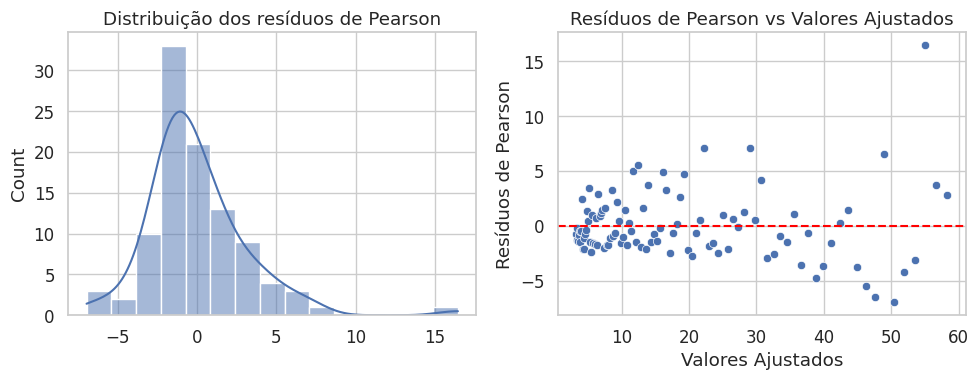

In [79]:
# ------------------------------------------------------------
# 4. Resíduos (Pearson e Deviance)
# ------------------------------------------------------------

# Resíduo de Pearson
pearson_resid = poisson_res.resid_pearson

# Resíduo de Deviance
deviance_resid = poisson_res.resid_deviance

# Visualizar distribuição dos resíduos
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(pearson_resid, bins=15, kde=True)
plt.title('Distribuição dos resíduos de Pearson')

plt.subplot(1, 2, 2)
sns.scatterplot(x=poisson_res.fittedvalues, y=pearson_resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Resíduos de Pearson vs Valores Ajustados')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos de Pearson')
plt.tight_layout()
plt.show()


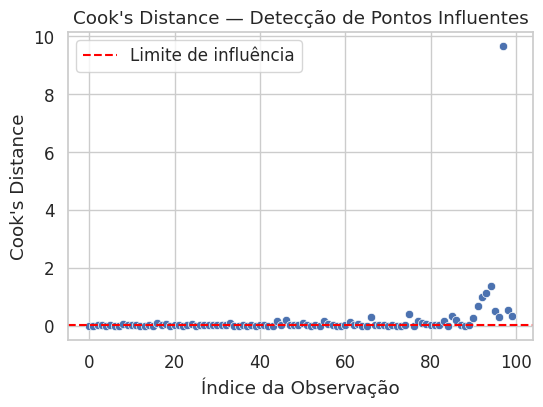


===== Diagnóstico de Influência =====
Observações influentes detectadas: [ 8 16 18 24 33 44 46 50 55 56 60 61 63 66 69 75 77 78 79 83 85 86 87 90
 91 92 93 94 95 96 97 98 99]


In [80]:
# ------------------------------------------------------------
# 5. Diagnóstico de Influência (Cook’s Distance)
# ------------------------------------------------------------

influence = poisson_res.get_influence()
cooks_d = influence.cooks_distance[0]  # valores de Cook

plt.figure(figsize=(6, 4))
sns.scatterplot(x=np.arange(len(cooks_d)), y=cooks_d)
plt.axhline(4/len(cooks_d), color='red', linestyle='--', label='Limite de influência')
plt.title("Cook's Distance — Detecção de Pontos Influentes")
plt.xlabel('Índice da Observação')
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

# Identificar observações potencialmente influentes
limite = 4 / len(cooks_d)
infl_indices = np.where(cooks_d > limite)[0]

print("\n===== Diagnóstico de Influência =====")
if len(infl_indices) > 0:
    print(f"Observações influentes detectadas: {infl_indices}")
else:
    print("✅ Nenhum ponto influente significativo detectado.")


In [81]:
# ------------------------------------------------------------
# 6. Interpretação final resumida
# ------------------------------------------------------------

print("\n===== Resumo Final =====")
print("1️⃣ A relação deviance/GL indica se há overdispersion.")
print("2️⃣ O gráfico de resíduos mostra se há padrões (mau ajuste).")
print("3️⃣ Cook’s distance identifica observações que afetam fortemente os coeficientes.")


===== Resumo Final =====
1️⃣ A relação deviance/GL indica se há overdispersion.
2️⃣ O gráfico de resíduos mostra se há padrões (mau ajuste).
3️⃣ Cook’s distance identifica observações que afetam fortemente os coeficientes.


# **Ajustar variantes (NegBin, quasi-Poisson, Gamma) quando necessário.**

In [82]:
# ============================================================
# Ajuste de Variantes do GLM: Negative Binomial, Quasi-Poisson e Gamma
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


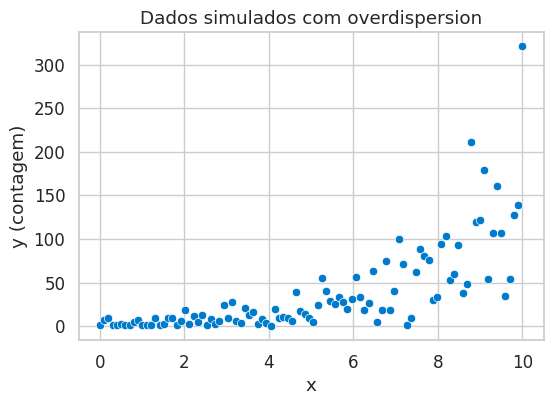

In [83]:

# ------------------------------------------------------------
# 1. Gerar dados simulados com OVERDISPERSION
# ------------------------------------------------------------

np.random.seed(123)

# Preditor x (ex: número de visitas)
x = np.linspace(0, 10, 100)

# Relação esperada
mu = np.exp(1 + 0.4 * x)

# Gerar contagens com overdispersion (via Negative Binomial)
y = np.random.negative_binomial(n=2, p=2/(2+mu))  # dispersão alta

df = pd.DataFrame({'x': x, 'y': y})

# Visualizar os dados
plt.figure(figsize=(6, 4))
sns.scatterplot(x='x', y='y', data=df, color='#007acc')
plt.title('Dados simulados com overdispersion')
plt.xlabel('x')
plt.ylabel('y (contagem)')
plt.show()

In [84]:
# ------------------------------------------------------------
# 2. Ajustar Modelo Poisson (referência)
# ------------------------------------------------------------

X = sm.add_constant(df['x'])
poisson_model = sm.GLM(df['y'], X, family=sm.families.Poisson())
poisson_res = poisson_model.fit()
print(poisson_res.summary())

# Calcular a razão deviance / GL
dispersion = poisson_res.deviance / poisson_res.df_resid
print(f"\nRazão Deviance/GL (Poisson): {dispersion:.2f}")

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -888.42
Date:                Mon, 10 Nov 2025   Deviance:                       1314.0
Time:                        00:42:26   Pearson chi2:                 1.28e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0281      0.062     16.626      0.0

In [85]:
# ------------------------------------------------------------
# 3. Ajustar Modelo Negative Binomial (corrige overdispersion)
# ------------------------------------------------------------

negbin_model = sm.GLM(df['y'], X, family=sm.families.NegativeBinomial())
negbin_res = negbin_model.fit()
print("\n===== Modelo Negative Binomial =====")
print(negbin_res.summary())



===== Modelo Negative Binomial =====
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -409.68
Date:                Mon, 10 Nov 2025   Deviance:                       50.988
Time:                        00:42:26   Pearson chi2:                     40.4
No. Iterations:                     6   Pseudo R-squ. (CS):             0.6787
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [86]:
# ------------------------------------------------------------
# 4. Ajustar Modelo Quasi-Poisson (dispersão livre)
# ------------------------------------------------------------

# Em Python, o Quasi-Poisson não está implementado diretamente,
# mas podemos ajustar o Poisson e ajustar a variância manualmente
# usando um "scale" personalizado (dispersão observada).

qp_model = sm.GLM(df['y'], X, family=sm.families.Poisson())
qp_res = qp_model.fit(scale=dispersion)
print("\n===== Modelo Quasi-Poisson (ajustado manualmente) =====")
print(qp_res.summary())


===== Modelo Quasi-Poisson (ajustado manualmente) =====
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          13.408
Method:                          IRLS   Log-Likelihood:                -66.261
Date:                Mon, 10 Nov 2025   Deviance:                       1314.0
Time:                        00:42:26   Pearson chi2:                 1.28e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9403
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------

In [87]:
# ------------------------------------------------------------
# 5. Ajustar Modelo Gamma (variável positiva contínua)
# ------------------------------------------------------------

# Exemplo: transformar contagem em tempo médio (para simular variável contínua positiva)
tempo = y + np.random.normal(0, 2, len(y)) + 5
tempo = np.clip(tempo, 0.1, None)  # evitar valores negativos

gamma_model = sm.GLM(tempo, X, family=sm.families.Gamma(link=sm.families.links.log()))
gamma_res = gamma_model.fit()
print("\n===== Modelo Gamma =====")
print(gamma_res.summary())


===== Modelo Gamma =====
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                         0.26318
Method:                          IRLS   Log-Likelihood:                -408.65
Date:                Mon, 10 Nov 2025   Deviance:                       30.941
Time:                        00:42:26   Pearson chi2:                     25.8
No. Iterations:                    12   Pseudo R-squ. (CS):             0.9515
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8618     

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


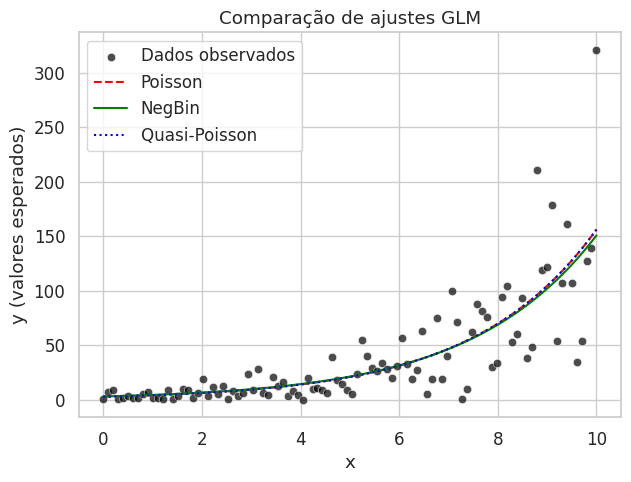

In [88]:
# ------------------------------------------------------------
# 6. Comparar os ajustes graficamente
# ------------------------------------------------------------

plt.figure(figsize=(7, 5))

sns.scatterplot(x='x', y='y', data=df, label='Dados observados', color='black', alpha=0.7)
plt.plot(df['x'], poisson_res.predict(X), label='Poisson', color='red', linestyle='--')
plt.plot(df['x'], negbin_res.predict(X), label='NegBin', color='green')
plt.plot(df['x'], qp_res.predict(X), label='Quasi-Poisson', color='blue', linestyle=':')
plt.title('Comparação de ajustes GLM')
plt.xlabel('x')
plt.ylabel('y (valores esperados)')
plt.legend()
plt.show()


In [89]:
# ============================================================
# Comparação de Modelos GLM — Poisson vs NegBin vs Gamma
# ============================================================

# Criar tabela de comparação
comparacao = pd.DataFrame({
    'Modelo': ['Poisson', 'NegBin', 'Quasi-Poisson', 'Gamma'],
    'AIC': [poisson_res.aic, negbin_res.aic, qp_res.aic, gamma_res.aic],
    'Deviance': [poisson_res.deviance, negbin_res.deviance, qp_res.deviance, gamma_res.deviance],
    'Dispersion': [dispersion,
                   negbin_res.deviance / negbin_res.df_resid,
                   qp_res.scale,
                   gamma_res.deviance / gamma_res.df_resid]
})

print("\n===== Comparação de Modelos =====")
print(comparacao.round(3))

# Destacar o melhor AIC
melhor = comparacao.loc[comparacao['AIC'].idxmin()]
print(f"\n🏆 Melhor modelo segundo AIC: {melhor['Modelo']} (AIC={melhor['AIC']:.2f})")

# ------------------------------------------------------------
# Pseudo R² (Nagelkerke ou McFadden)
# ------------------------------------------------------------

def pseudo_r2(model):
    llf = model.llf  # log-likelihood do modelo ajustado
    llnull = model.null_deviance / -2  # log-likelihood do modelo nulo
    return 1 - (llf / llnull)

comparacao['Pseudo_R2'] = [
    pseudo_r2(poisson_res),
    pseudo_r2(negbin_res),
    pseudo_r2(qp_res),
    pseudo_r2(gamma_res)
]

print("\n===== Tabela com Pseudo R² =====")
print(comparacao[['Modelo', 'AIC', 'Pseudo_R2']].round(3))



===== Comparação de Modelos =====
          Modelo       AIC  Deviance          Dispersion
0        Poisson  1780.849  1313.980           13.407956
1         NegBin   823.362    50.988            0.520288
2  Quasi-Poisson   136.522  1313.980  13.407956499532094
3          Gamma   821.303    30.941            0.315727

🏆 Melhor modelo segundo AIC: Quasi-Poisson (AIC=136.52)

===== Tabela com Pseudo R² =====
          Modelo       AIC  Pseudo_R2
0        Poisson  1780.849      0.651
1         NegBin   823.362     -3.980
2  Quasi-Poisson   136.522      0.974
3          Gamma   821.303     -6.391


In [90]:
# ------------------------------------------------------------
# 7. Interpretação final
# ------------------------------------------------------------

print("\n===== Interpretação =====")
print("👉 O modelo Poisson assume que Var(Y) = E(Y).")
print("👉 O modelo Negative Binomial permite Var(Y) > E(Y).")
print("👉 O Quasi-Poisson ajusta a dispersão com um fator empírico.")
print("👉 O modelo Gamma é indicado quando Y é contínua positiva.")
print(f"Razão de dispersão (Poisson): {dispersion:.2f}")


===== Interpretação =====
👉 O modelo Poisson assume que Var(Y) = E(Y).
👉 O modelo Negative Binomial permite Var(Y) > E(Y).
👉 O Quasi-Poisson ajusta a dispersão com um fator empírico.
👉 O modelo Gamma é indicado quando Y é contínua positiva.
Razão de dispersão (Poisson): 13.41


Ajustando Variantes do GLM quando há Overdispersion”

| Modelo            | Família           | Quando usar              | Link |
| :---------------- | :---------------- | :----------------------- | :--- |
| Poisson           | Contagens         | Variância ≈ Média        | Log  |
| Quasi-Poisson     | Contagens         | Variância > Média (leve) | Log  |
| Negative Binomial | Contagens         | Overdispersion forte     | Log  |
| Gamma             | Contínua positiva | Tempo, custo, duração    | Log  |
